# Comparing theory to DTS observed stability

__Problem Statement__:
It is well known that Monin-Obukhov Similarity Theory does not describe turbulence in the very stable boundary layer. I suspect at least part of that failure is a poor definition of stability from point observations relative to the spatially-continuous observations from DTS. I want to determine if there is promise in pursuing this line of inquiry.

__Goals of Notebook__:
- Compare MOST quantities derived from CSATs directly to the temperature profile
- Evaluate using a Bayes model to directly model MOST parameters

DTS stability were estimated using a log-linear Bayes GLM assuming that errors were distributed as Student's t distributions. These inferences were made in `estimating-stability_bayesian-stats.v2-2021-02-18.ipynb`


# 1. Import and formatting

In [1]:
# Data and methods libraries
import numpy as np
import xarray as xr
import scipy.stats
import pandas as pd

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
import pymc3 as pm
import warnings

## Format plots

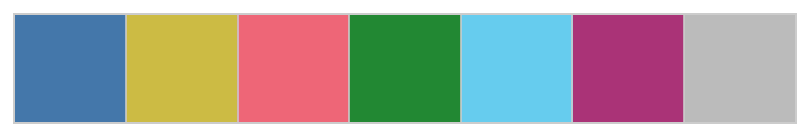

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = ['#4477AA', '#CCBB44', '#EE6677', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
sns.set_palette(sns.color_palette(tol_bright_reorder))
sns.palplot(tol_bright_reorder)

## Directories

In [3]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Met data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_aws_data = os.path.join(dir_logger_data, 'AWS')
dir_csat_stats = os.path.join(dir_logger_data, 'CSATs', 'stats')
dir_csat_flux = os.path.join(dir_logger_data, 'CSATs', 'fluxes')
dir_csat_corr = os.path.join(dir_logger_data, 'CSATs', 'csat-Ts-correction')
dir_ceil = os.path.join(dir_pre, 'love_dts/ESSD-repository/remote-sensing/ceilometer/')
dir_press = os.path.join(dir_logger_data, 'pressure')
dir_bayes_glm = os.path.join(dir_pre, 'love_dts', 'bayes_glm')
dir_homogenized_data = os.path.join(dir_pre, 'homogenized_data')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'AncillaryMet')


# 2. Load data

## 2.1 Homogenized data

Use the homogenized data from `homogenizing-stability-data.ipynb`

In [4]:
os.chdir(dir_homogenized_data)

sonic_1min = xr.open_dataset('sonics_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
sonic_10min = xr.open_dataset('sonics_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta = xr.open_dataarray('aws_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta_10min = xr.open_dataarray('aws_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
tower = xr.open_dataset('tower_pot-temp_1s_qc_tower-subset.v1-2021-02-22.nc')
tower_1min = xr.open_dataset('tower_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')


## 2.2 Tower 10min Bayesian modeling output

In [5]:
os.chdir(dir_bayes_glm)
tower_10min = xr.open_dataset('tower_10min_bayes_glm.nc')

## 2.2 Ceilometer, AWS, and pressure data

- Ceilometer for cloudiness
- AWS for radiation and RH
- pressure for potential temperature calculations

In [6]:
os.chdir(dir_ceil)
ceilo = xr.open_dataset('ceiolometer-combined-files_2019_June01-Aug15.nc')
ceilo = ceilo.reindex_like(sonic_1min.time, method='nearest')
ceilo_10min = ceilo.interp_like(tower_10min.time, method='nearest')

In [7]:
os.chdir(dir_aws_data)
aws_10min = xr.open_dataset('AWS_Voi_10min.nc')

## 2.3 Quickly estimate stability using the CSATs

In [8]:
sonic_10min['ols_m'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_r'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_p'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_b'] = (('time'), np.zeros(len(sonic_10min.time.values)))


In [9]:
for t in sonic_10min.time:
    ds = sonic_10min.sel(time=t).theta

    result_dts = scipy.stats.linregress(np.log(ds.z), ds.values)
    sonic_10min['ols_m'].loc[{'time': t}] = result_dts.slope
    sonic_10min['ols_r'].loc[{'time': t}] = result_dts.rvalue
    sonic_10min['ols_p'].loc[{'time': t}] = result_dts.pvalue
    sonic_10min['ols_b'].loc[{'time': t}] = result_dts.intercept

## 2.4 Create a gappy version of the 10min DTS tower data

In [10]:
dt = pd.date_range(
    start=pd.Timestamp(tower_10min.time[0].values),
    end=pd.Timestamp(tower_10min.time[-1].values),
    freq='10min',
)

tower_10min_nanfill = tower_10min.reindex(time=dt, tolerance=1, method='nearest')

# 3. MOST, vertical temperature gradients, and implications for theory

## 3.1 prepare the data and model priors

We are going to re-examine the period of interest from the notebook `bayesian-GLM_estimate-dTdlnz.ipynb`

Text(0, 0.5, '$\\theta$ (C)')

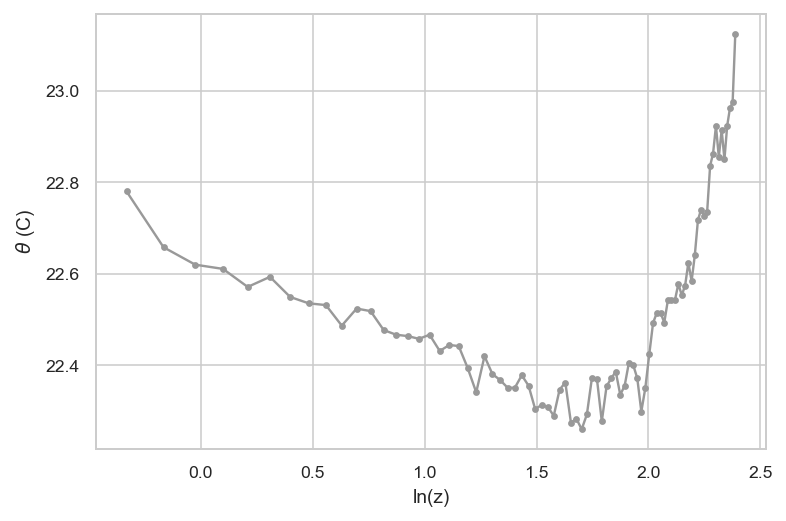

In [12]:
t_interest = pd.Timestamp('2019-07-27 04:50')

ds_bayes_GLM = tower_10min.sel(time=t_interest)
ds_sonic = sonic_10min.sel(time=t_interest)

# And plot it
ds_bayes_GLM["sigma_theta"] = 0.15
plt.plot(
    ds_bayes_GLM.lnz,
    ds_bayes_GLM.theta_mean,
    color='0.6',
    marker='.')
plt.gca().set_xlabel('ln(z)')
plt.gca().set_ylabel(r'$\theta$ (C)')

and now the model priors. The model priors = MOST assumptions

In [14]:
def yang_08(ustar, tstar, z0Ground, airTemp, mHeight):
    '''
    As implemented in NoahMPv1.1
    '''
    if np.max(airTemp) < 200:
        airTemp = airTemp + 273.15
    
    # Constants
    beta = 7.2  # m^(-1/2) s^(1/2) K^(-1/4)
    m = 0.5
    n = 0.25
    # Kinematic viscosity (as estimated in Andreas 1987)
    kinvisc = (1. * 10.**7. / (.9065 * airTemp - 112.7)) ** (-1.)

    z0Ground = 70 * kinvisc / ustar * np.exp(-beta * ustar**(m)
                                             * np.abs(tstar)**(n))
    z0Groundh = z0Ground
    z0Groundq = z0Ground

    # Log profiles
    dlogT = np.log(mHeight / z0Groundh)
    dlogQ = np.log(mHeight / z0Groundq)

    return (z0Groundh, z0Groundq, dlogQ, dlogT)

In [15]:
# From processing the CSAT observations using typical micrometeorological approaches
z0 = 0.366667

z0_t_est, _, _, _ = yang_08(
    ds_sonic['u*'].sel(names='1m').values,
    ds_sonic.wTs.sel(names='1m').values,
    z0,
    ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest').values,
    1.)
print(z0_t_est)

0.019618888644825527


In [16]:
# From previous work
param_studentt = [0] * 3
param_studentt[0] = 3.053390435630643
param_studentt[1] = -0.0023708708481033312
param_studentt[2] = 0.05457303519244836

theta_star = (ds_sonic.wTs / ds_sonic['u*'])
theta_star_profile_avg = theta_star.mean(dim='names').values

b0_most = ds_bayes_GLM.theta_mean.swap_dims({'xyz': 'z'}).sel(z=0, method='nearest') - theta_star / (0.4 * np.log(z0_t_est))

b1_most = theta_star / (0.4 * np.log(z0_t_est))

b1_guess = b1_most.sel(names='1m')
b0_guess = b0_most.sel(names='1m')

print('Initial guess for the slope={:2.3f}K/ln(m)'.format(b1_guess.values))
print('Initial guess for the intercept={:2.3f}K'.format(b0_guess.values))

Initial guess for the slope=-0.024K/ln(m)
Initial guess for the intercept=22.805K


In [17]:
x = ds_bayes_GLM.lnz
y = ds_bayes_GLM.theta_mean

with pm.Model() as mdl_hogg:

    # state input data as Theano shared vars
    tsv_x = pm.Data("tsv_x", x.values)  # (n, )
    tsv_y = pm.Data("tsv_y", y.values)  # (n, )
    tsv_sigma_y = pm.Data("tsv_sigma_y", param_studentt[2])  # (1, )

    # weakly informative Normal priors (L2 ridge reg) for inliers
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=0.5, testval=pm.floatX(0.0))
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=b1_guess.values, sigma=0.5, testval=pm.floatX(1.0))

    # linear model for mean for inliers
    y_est_in = b0 + b1 * tsv_x  # (n, )

    # very weakly informative mean for all outliers
    y_est_out = pm.Normal("y_est_out", mu=0, sigma=0.6, testval=pm.floatX(0.0))  # (1, )

    # very weakly informative prior for additional variance for outliers
    # The physical interpretation here is that points impacted by artifacts may have
    # a different variance than points impacted by just the atmosphere
    sigma_y_out = pm.HalfNormal("sigma_y_out", sigma=1, testval=pm.floatX(1.0))  # (1, )

    # create in/outlier distributions to get a logp evaluated on the observed y
    # this is not strictly a pymc3 likelihood, but behaves like one when we
    # evaluate it within a Potential (which is minimized)
    inlier_logp = pm.Normal.dist(mu=y_est_in, sigma=tsv_sigma_y).logp(tsv_y)

    outlier_logp = pm.Normal.dist(mu=y_est_out, sigma=tsv_sigma_y + sigma_y_out).logp(tsv_y)

    # frac_outliers only needs to span [0, .5]
    # testval for is_outlier initialised in order to create class asymmetry
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli(
        "is_outlier",
        p=frac_outliers,
        shape=tsv_x.eval().shape[0],
        testval=(np.random.rand(tsv_x.eval().shape[0]) < 0.3) * 1,
    )  # (n, )

    # non-sampled Potential evaluates the Normal.dist.logp's
    potential = pm.Potential(
        "obs",
        ((1 - is_outlier) * inlier_logp).sum() + (is_outlier * outlier_logp).sum(),
    )

In [18]:
with mdl_hogg:
    trc_hogg = pm.sample(
        tune=5000,
        draws=500,
        chains=2,
        cores=2,
        init="jitter+adapt_diag",
        nuts={"target_accept": 0.9},
        progressbar=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, y_est_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:24<00:00, 449.75draws/s]


In [19]:
cutoff = 0.05
ds_bayes_GLM.coords["classed_as_outlier"] = (('xyz'), np.quantile(trc_hogg["is_outlier"], cutoff, axis=0) == 1)
print('Number of Outliers={}'.format(ds_bayes_GLM["classed_as_outlier"].sum().values))

Number of Outliers=14


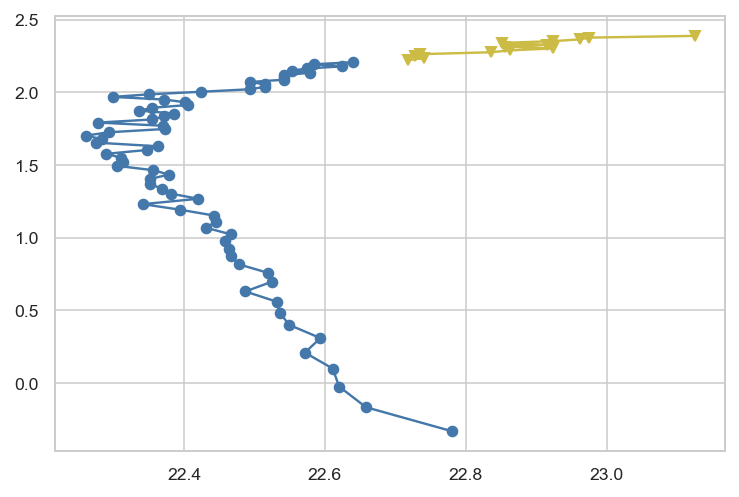

In [20]:
inlier = ds_bayes_GLM.theta_mean.where(ds_bayes_GLM.classed_as_outlier == 0, drop=True)
outlier = ds_bayes_GLM.theta_mean.where(ds_bayes_GLM.classed_as_outlier == 1, drop=True)
plt.plot(inlier.values, inlier.lnz, label='inlier', marker='o')
plt.plot(outlier.values, outlier.lnz, label='outlier', marker='v')


# 4. Modeling MOST with stability corrections directly

In [21]:
import turbpy


sfcTemp = 290
airTemp = np.arange(275, 315, 0.25)
windspd = 2
mHeight = 2.
z0Ground = z0_t_est
snowDepth = 0.
scalarGroundSnowFraction  = 0.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPress = 95000.

RiBulk = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

# stab_titles are the names given to each stability scheme when plotting. In this example they correspond 
# to the dictionaries that contain the parameter values for each run. T
stab_titles = ('MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              )

# A mapping between the titles and the stability methods used in each test.
stab_methods = {'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

# Thes gradient functions for the Monin-Obukhov methods
gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

# Indicates which methods have capping of the conductance. Any method without capping 
# indicated is assumed to have no capping.
capping = {
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]


In [22]:
import turbpy.multiConst as mc


# Initialzie dictionaries for containing output
psiH = {}
psiM = {}
L = {}
zeta = {}
zetaT = {}

for stab in stab_titles:
    psiH[stab] = np.zeros_like(RiBulk)
    psiM[stab] = np.zeros_like(RiBulk)
    L[stab] = np.zeros_like(RiBulk)
    zeta[stab] = np.zeros_like(RiBulk)
    zetaT[stab] = np.zeros_like(RiBulk)

    # Get the parameters for running turbpy.
    param_dict = turbpy.parameter_methods.get_params(stab_dict[stab])
    
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):

        ########
        # Local variables
        volHeatCapacityAir = mc.iden_air * mc.Cp_air              # volumetric heat capacity of air (J m-3)
        latentHeatConstant = mc.iden_air * mc.w_ratio / airPress  # latent heat constant for (kg m-3 Pa-1)

        #######
        # Latent Heat - Vaporization or sublimation.
        # NOTE: The physics implied here may be wrong. Point to bring up with Martyn/Bart
        latHeatSubVapGround = mc.LH_vap
        latHeatSubVapGround = mc.LH_sub

        # compute the gradient/stability corrections
        _, stabOut, _, _ = turbpy.aStability(
            param_dict,                # parameter defining dictionary
            mHeight,         # measurement height (m)
            tair,                   # air temperature @ mHeight (K)
            vp,             # vapor pressure @ mHeight (Pa)
            sfcTemp,                   # ground temperature (K)
            sfcVaporPress,             # vapor pressure @ surface (Pa)
            windspd,                   # wind speed at @ mHeight (m s-1)
            z0Ground,                  # surface roughness length (m)
        )

        # Unpack
        psiH[stab][n] = stabOut['psiH']
        psiH[stab][n] = stabOut['psiH']
        L[stab][n] = stabOut['L']
        zeta[stab][n] = stabOut['zeta']
        zetaT[stab][n] = stabOut['zetaT']
        

/Users/karllapo/anaconda3/envs/py_ml/lib/python3.8/site-packages/turbpy/parameter_methods.py:18: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  param_dict = yaml.load(ymlfile)


In [ ]:
csat_colors = ['0.2', '0.5', '0.7', '1']
fig, ax = plt.subplots(1, 1)
for stab in stab_titles:
    ax.plot(L[stab], psiH[stab], label=stab, marker='o', linestyle='None')
ax.set_ylim(-5, 2)
ax.set_xlim(-20, 20)
ax.set_ylabel(r'$\Psi_H$')
ax.set_xlabel('L')
for n, names in enumerate(ds_sonic.names):
    ax.plot(
        ds_sonic.sel(names=names).L.values,
        1.5, 
        color=csat_colors[n],
        marker='v',
        markersize=15,
        markeredgecolor='k',
        markeredgewidth=1,
        linestyle='None'
    )
ax.legend()

fig, ax = plt.subplots(1, 1)
for stab in stab_titles:
    ax.plot(RiBulk, psiH[stab], label=stab, marker='o', linestyle='None')
ax.set_ylim(-20, 2)
ax.set_ylabel(r'$\Psi_H$')
ax.set_xlabel('$Ri_{bulk}$')
ax.legend()

$\Psi_H$ has the expected behavior change between stable and unstable conditions. This unfortunately has the side effect of making the Bayesian GLM search unstable if I allow the Psi parameter to search on both sides of the behavior. To avoid this, I will do the fit in two parts: 1) fit the lower unstable profile and 2) fit the upper stable profile

I will use the custom likelihood classifier to distinguish between these two.

In [24]:
x = inlier.lnz
y = inlier
tstar = theta_star.sel(names='1m')
lnzt = np.log(z0_t_est)
L = ds_sonic.L.sel(names='1m')

with pm.Model() as mdl_stability_studentt:

    # define weakly informative Normal priors to give Ridge regression
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=1)
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=tstar.values, sigma=0.5)
    # The stability correction -- no idea what this is at the moment
    b2 = pm.InverseGamma('b2_correction', mu=1, sigma=1)
    
    # define linear model
    y_est = b0 + (b1 * x) * (1 / z0_t_est - b2 / L)

    # define prior for StudentT degrees of freedom
    # The student t I fit above used a Gamma dist. for degrees of freedom:
    # it's continuous and has support x ∈ (0, inf)
    # I can use the dof defined previously as a starting point.
    # There are two ways to define the distribution:
    #    1) alpha and beta parameters
    #    2) a mean and standard deviation
    # I will use option 2 since I estimated the dof directly, which should
    # correspond to the mean of the distribution.
    nu = pm.Gamma(
        "nu",
        mu=param_studentt[0],
        sigma=2)
   
    # define Student T likelihood
    # The "scale" parameter is given from the above analysis
    likelihood = pm.StudentT(
        "likelihood",
        mu=y_est,
        sigma=param_studentt[2],
        nu=nu,
        observed=y.values)

In [25]:
with mdl_stability_studentt:
    trc_studentt = pm.sample(
        tune=5000,
        draws=500,
        chains=2,
        cores=2,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 203.85:  29%|██▉       | 14551/50000 [00:02<00:07, 4924.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = -27.094:  69%|██████▉   | 34719/50000 [00:06<00:02, 5498.74it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b2_correction, b1_slope, b0_intercept]
Sampling 2 chains, 0 dive

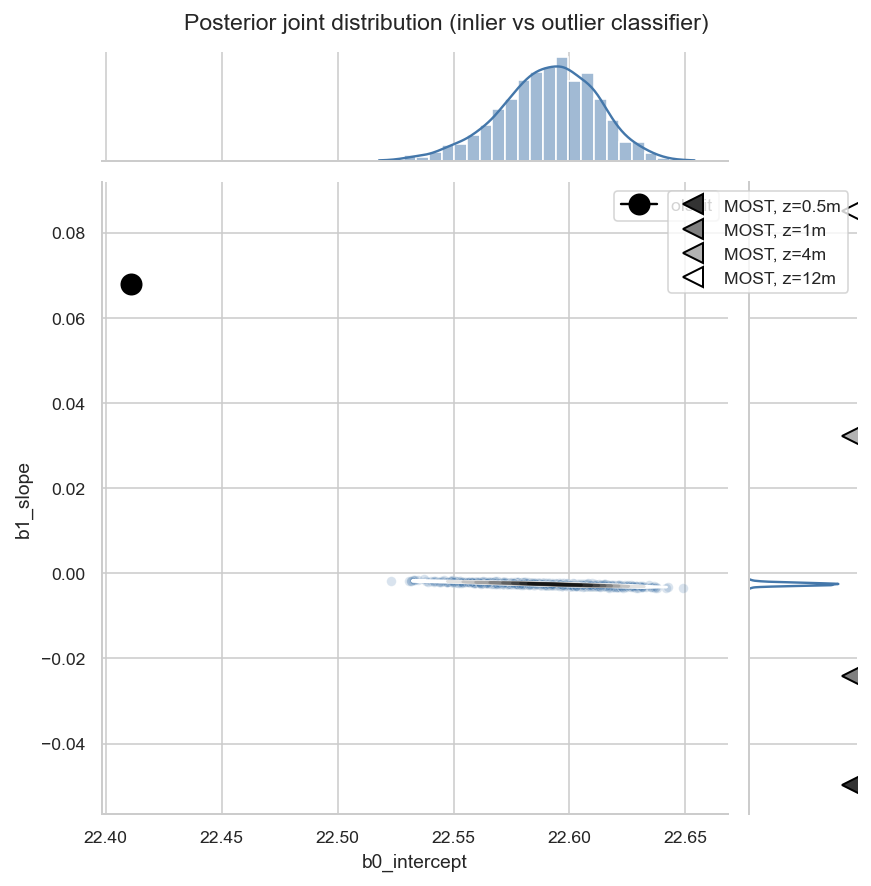

In [27]:
df_trc_multi = pm.trace_to_dataframe(trc_studentt)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_multi,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (inlier vs outlier classifier)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()

No handles with labels found to put in legend.


(0.0, 1.5)

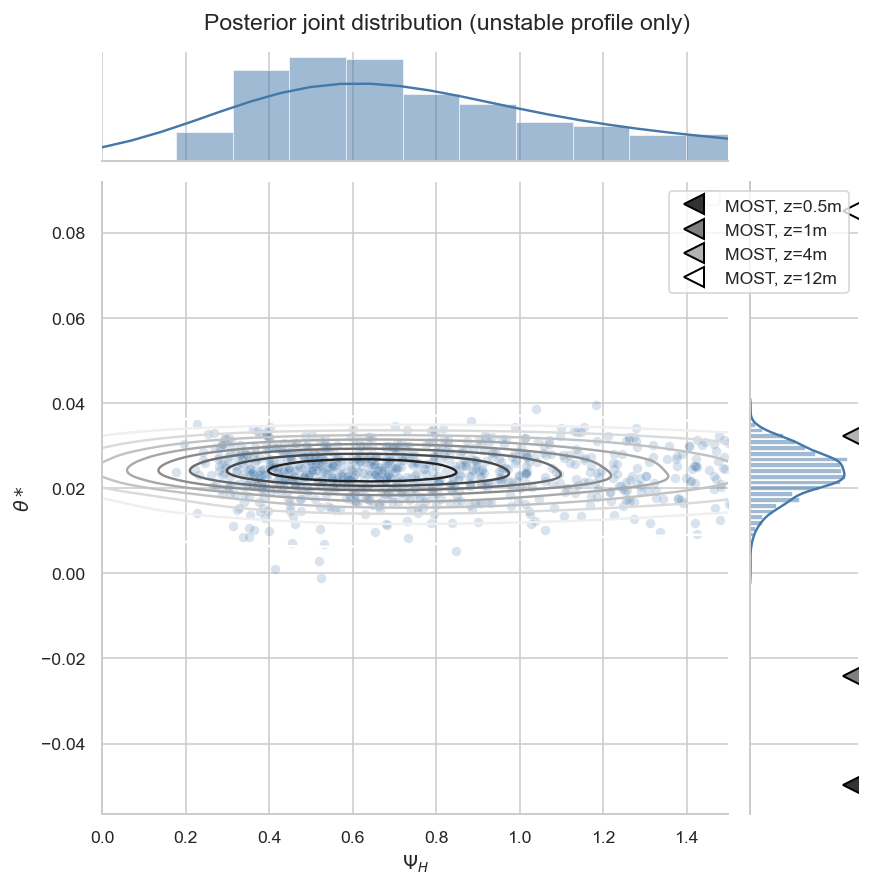

In [30]:
df_trc_multi = pm.trace_to_dataframe(trc_studentt)
gd = sns.jointplot(
    x="b2_correction",
    y="b1_slope",
    data=df_trc_multi,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
gd.ax_joint.set_xlabel(r'$\Psi_H$')
gd.ax_joint.set_ylabel(r'$\theta*$')
_ = gd.fig.suptitle("Posterior joint distribution (unstable profile only)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()
gd.ax_joint.set_xlim(0, 1.5)

In [29]:
x = outlier.lnz
y = outlier
tstar = theta_star.sel(names='1m')
lnzt = np.log(z0_t_est)
L = ds_sonic.L.sel(names='1m')

with pm.Model() as mdl_stability_studentt:

    # define weakly informative Normal priors to give Ridge regression
    # I want the model to search for an intercept temperature close to what I can estimate
    b0 = pm.Normal("b0_intercept", mu=b0_guess.values, sigma=1)
    # I don't want the model searching for a slope far away from the initial guess
    b1 = pm.Normal("b1_slope", mu=tstar.values, sigma=0.5)
    # The stability correction -- no idea what this is at the moment
    b2 = pm.InverseGamma('b2_correction', mu=1, sigma=1)
    
    # define linear model
    y_est = b0 + (b1 * x) * (1 / z0_t_est + b2 / L)

    # define prior for StudentT degrees of freedom
    # The student t I fit above used a Gamma dist. for degrees of freedom:
    # it's continuous and has support x ∈ (0, inf)
    # I can use the dof defined previously as a starting point.
    # There are two ways to define the distribution:
    #    1) alpha and beta parameters
    #    2) a mean and standard deviation
    # I will use option 2 since I estimated the dof directly, which should
    # correspond to the mean of the distribution.
    nu = pm.Gamma(
        "nu",
        mu=param_studentt[0],
        sigma=2)
   
    # define Student T likelihood
    # The "scale" parameter is given from the above analysis
    likelihood = pm.StudentT(
        "likelihood",
        mu=y_est,
        sigma=param_studentt[2],
        nu=nu,
        observed=y.values)
    
with mdl_stability_studentt:
    trc_studentt = pm.sample(
        tune=5000,
        draws=500,
        chains=2,
        cores=2,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
    )
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 61.635:  28%|██▊       | 14204/50000 [00:02<00:06, 5741.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, b2_correction, b1_slope, b0_intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:42<00:00, 257.94draws/s]


No handles with labels found to put in legend.


(0.0, 1.5)

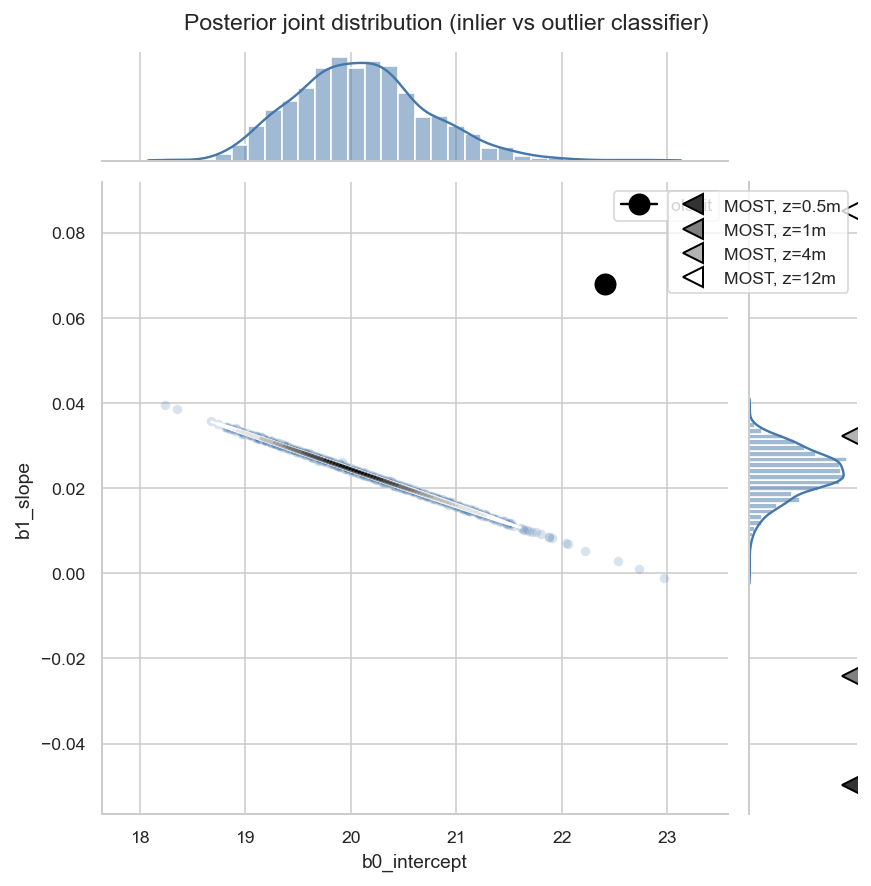

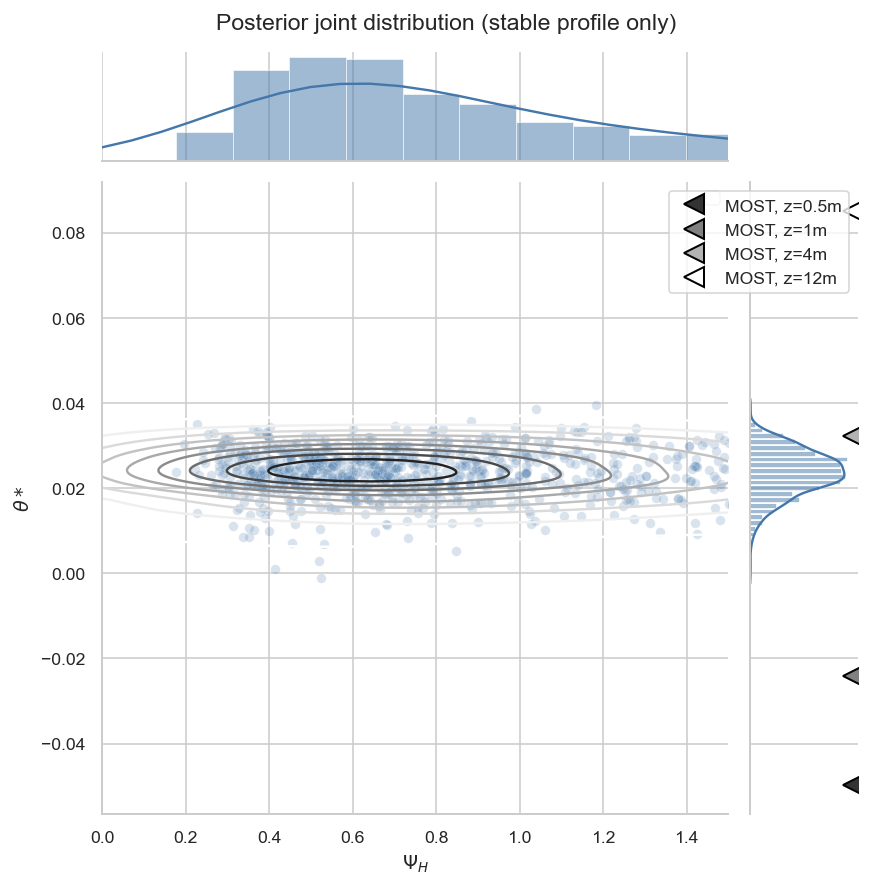

In [32]:
df_trc_multi = pm.trace_to_dataframe(trc_studentt)
gd = sns.jointplot(
    x="b0_intercept",
    y="b1_slope",
    data=df_trc_multi,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
_ = gd.fig.suptitle("Posterior joint distribution (inlier vs outlier classifier)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
gd.ax_joint.plot(
    ds_bayes_GLM['ols_b'].values,
    ds_bayes_GLM["ols_m"].values,
    marker='o',
    color='k',
    label='ols fit',
    markersize=10
)

_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()

# -------------------------------------------------------
df_trc_multi = pm.trace_to_dataframe(trc_studentt)
gd = sns.jointplot(
    x="b2_correction",
    y="b1_slope",
    data=df_trc_multi,
    height=6,
    marginal_kws={"kde": True, "kde_kws": {"cut": 1}},
    joint_kws={"alpha": 0.2},
)
gd.plot_joint(sns.kdeplot, zorder=2, n_levels=10, cmap="gray_r")
gd.ax_joint.set_xlabel(r'$\Psi_H$')
gd.ax_joint.set_ylabel(r'$\theta*$')
_ = gd.fig.suptitle("Posterior joint distribution (stable profile only)", y=1.02)

csat_colors = ['0.2', '0.5', '0.7', '1']
_, xloc = gd.ax_marg_y.get_xlim()

for n, names in enumerate(b1_most.names):
    gd.ax_marg_y.plot(
        xloc,
        b1_most.sel(names=names),
        linestyle='None',
        marker='<',
        markeredgecolor='k',
        markeredgewidth=1,
        color=csat_colors[n],
        label='MOST, z={}'.format(names.values),
        markersize=10)
gd.ax_joint.legend()
gd.ax_marg_y.legend()
gd.ax_joint.set_xlim(0, 1.5)